In [25]:
import numpy as np
import matplotlib.pyplot as plt

Our first task is to simulate the flow of heat in a solid.

The heat flow equation is:

$$ \frac{\partial u}{\partial t} = \frac{K}{C\rho}\nabla^2 u $$

$$ = \frac{K}{C\rho} \Big(\frac{\partial^2 u}{\partial x^2}
+ \frac{\partial^2 u}{\partial y^2}
+ \frac{\partial^2 u}{\partial z^2}\Big) $$

Where $K$ is the thermal conductivity, $C$ is the specific heat, and $\rho$ is the density. For brevity, I will define $A = \frac{K}{C\rho}$.

We solve this using a timestep algorithm.

At a given point $u_i(t_{i})$, the spatial derivatives can be expressed in discrete form:
$$ \frac{\partial^2 u}{\partial x^2} = \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} $$

And the time derivative can be expressed as:
$$ \frac{\partial u}{\partial t} = \frac{u(t_{j+1}) - u(t_j)}{\Delta t} $$

Given a particular temperature distribution, we may find the next iteration using the following time step equation:

$$ u_{i,j,k}(t_{j+1}) = u_{i,j,k}(t_j)
 + A\Big(
         \frac{u_{i+1,j,k} - 2u_{i,j,k} + u_{i-1,j,k}}{\Delta x^2}
         + \frac{u_{i,j+1,k} - 2u_{i,j,k} + u_{i,j-1,k}}{\Delta y^2}
         + \frac{u_{i,j,k+1} - 2u_{i,j,k} + u_{i,j,k-1}}{\Delta z^2}
    \Big) \Delta t $$

If we take the same spatial step size for each dimension, we may simplify the expression in parentheses:
$$ \Big(u_{i+1,j,k} + u_{i,j+1,k} + u_{i,j,k+1} + u_{i-1,j,k} + u_{i,j-1,k} + u_{i,j,k-1} - 6u_{i,j,k}\Big)
\cdot\frac{1}{\Delta x^2}
$$
$$
= \frac{1}{\Delta x^2} \Big(\sum_{adjacent} u(t_j)\Big) - 6u_{i,j,k}
$$

Thus, we have:
$$ u_{i,j,k}(t_{j+1}) = u_{i,j,k}(t_j)
+ \frac{1}{\Delta x^2} \Big(\sum_{adjacent} u(t_j)\Big) - 6u_{i,j,k}
$$

To handle an insulated boundary, we introduce fictional points such that the derivative will always be zero.

As a simplified case, we assume that the non-insulated boundaries are in perfect thermal contact with a heat sink at a constant temperature.


### First step: Boundary Conditions ###

First I write a function that updates the fictional points. For the insulated boundaries, the fictional points are just outside the boundary and have the same temperature as the boundary.

For non-insulated boundaries, the points are held at a fixed temperature.

In [2]:
def updateBoundary(T, T_ext):
    """
    Updates the boundary points for the thermal conductor.
    The bottom surface of the conductor (where the first index is zero)
    is assumed to have perfect thermal contact with the surroundings,
    and will be held at temperature T_ext.
    
    The NumPy array is modified in-place.
    
    Arguments:
    ---------
    - T: a 3d array of temperatures within the solid. The shape of the
         array must be (h+1, w+2, d+2) to include the fictional points
         on 5 of the 6 surfaces.
         
    - T_ext: Temperature of the external environment
    
    Returns:
    ------
    Nothing
    
    """
    # Thermal conductive surface
    T[0,:,:] = T_ext
    
    # Insulated surfaces
    T[-1,:,:] = T[-2,:,:]
    T[:,0,:] = T[:,1,:]
    T[:,-1,:] = T[:,-2,:]
    T[:,:,0] = T[:,:,1]
    T[:,:,-1] = T[:,:,-2]
    

In [16]:
a = np.array([1, 2, 3, 1, 4])
np.roll(a, -1, axis=0)


array([2, 3, 1, 4, 1])

In [54]:
def thermalSimulate(T, t, dx=0.1, K=0.01, CR=1, T_ext=0):
    """
    Simulates the diffusion of heat through a solid with an initial
    temperature distribution given by T. One boundary of the solid
    (where the first index is zero) is assumed to be in perfect
    thermal contact with the surroundings. The other boundaries
    are insulated.
    
    Arguments:
    ---------
    - T: a 3D NumPy array containing the initial temperature distribution.
         If the actual dimensions of the solid are i, j, and k, then the
         array should have dimensions i+1, j+2, and k+2.
         
    - t: an array containing the simulation times
    
    - dx: the separation between adjacent points in the solid
    
    - K: the thermal conductivity
    
    - CR: the specific heat capacity times the density, or equivalently,
        the heat capacity per unit volume.
    
    - T_ext: the temperature of the external heat sink
    
    Returns:
    -------
    - simulation: a 4D NumPy array containing the results of the
         simulation, with the first three indices corresponding to
         the spatial coordinates, and the fourth index corresponding
         to the time
    
    """
    # Make an empty array with an extra axis for time
    simulation = np.zeros(T.shape+(len(t),))
    
    # Assume uniform times.
    dt = t[1]-t[0]
    
    # Prefactor
    A = K/CR
    
    
    # First entry
    currentT = T.copy()
    updateBoundary(currentT, T_ext)
    simulation[:,:,:,0] = currentT
    
    # Iterate!
    for i in range(1,len(t)):
        
        # Calculate the stuff as described in the project notebook
        T_sum = np.roll(currentT, -1, axis=0) + np.roll(currentT, 1, axis=0) \
              + np.roll(currentT, -1, axis=1) + np.roll(currentT, 1, axis=1) \
              + np.roll(currentT, -1, axis=2) + np.roll(currentT, 1, axis=2)
        deltaT = A*(T_sum - 6*currentT)/(dx**2) * dt
        
        # Update the temperature
        currentT = currentT + deltaT
        
        # Update the boundary, since we probably messed it up
        updateBoundary(currentT, T_ext)
        
        # Add to the simulation
        simulation[:,:,:,i] = currentT
    
    return simulation

### Step 3: Testing the Simulation ###

First a simple test: if the solid begins at zero, with a nonzero external temperature, will the temperature equalize?

In [87]:
# Initial temperature 0K
T = np.zeros((11, 12, 12))

# Time span of 100 seconds
t=np.linspace(0, 100, 1000)

# Simulate with an external temperature of 10 K
sim = thermalSimulate(T, t, T_ext=10)


<Figure size 640x480 with 0 Axes>

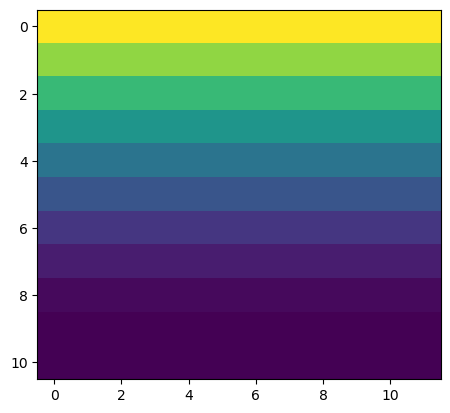

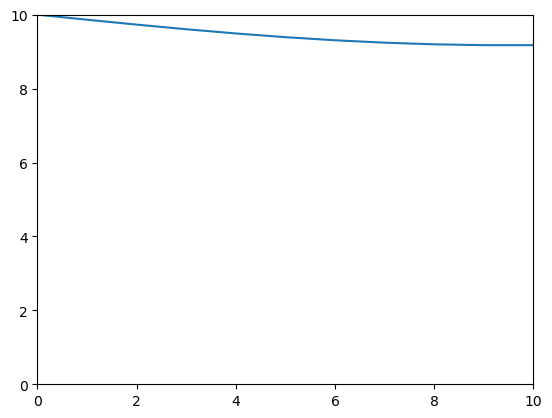

<Figure size 640x480 with 0 Axes>

In [103]:
# Display a cross section from the middle of the solid
# observed at the end of the simulation
plt.imshow(sim[:,5,:,-1])
plt.figure()
# Plot the temperature from the insulated to the
# non-insulated end
plt.plot(sim[:,5,5,-1])
plt.ylim(0,10)
plt.xlim(0,10)
plt.figure()

Now run the simulator with a single photon strike at the top center.

In [185]:
# Initial temperature 0K
T = np.ones((12, 13, 13))*4
T[10,6,6] = 44

# Time span of 100 seconds
t=np.arange(0, 100, 0.1)

# Simulate with an external temperature of 10 K
sim = thermalSimulate(T, t, T_ext=4)

<Figure size 640x480 with 0 Axes>

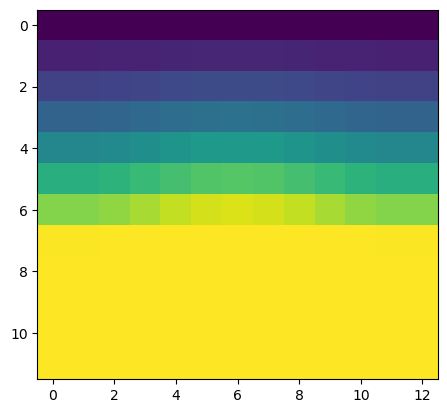

<Figure size 640x480 with 0 Axes>

In [170]:
plt.imshow(sim[:,6,:,100], vmin=4, vmax=4.05)
# plt.imshow(T[:,6,:])
plt.figure()

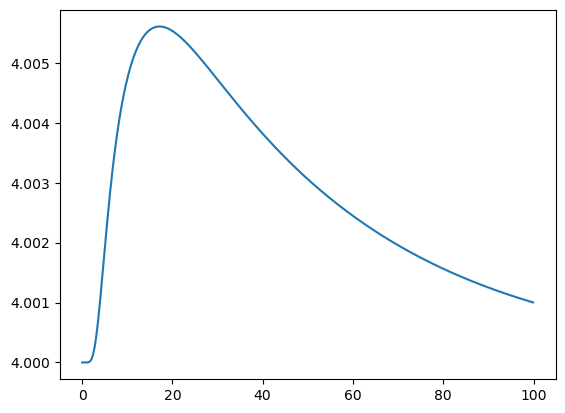

In [186]:
t_signature = sim[1,6,6,:]
plt.plot(t,t_signature)

In [208]:
def getSignature(p_loc, p_energy, dt=0.1, tmax=100, T_ext=4, sensor_loc=(1, 6, 6)):
    # Initial temperature
    T = np.ones((12, 13, 13))*T_ext
    T[p_loc[0], p_loc[1], p_loc[2]] = T_ext + p_energy

    t=np.arange(0, tmax, dt)

    sim = thermalSimulate(T, t, T_ext=T_ext)
    
    signature = sim[sensor_loc[0],sensor_loc[1],sensor_loc[2],:]
    
    return t, signature

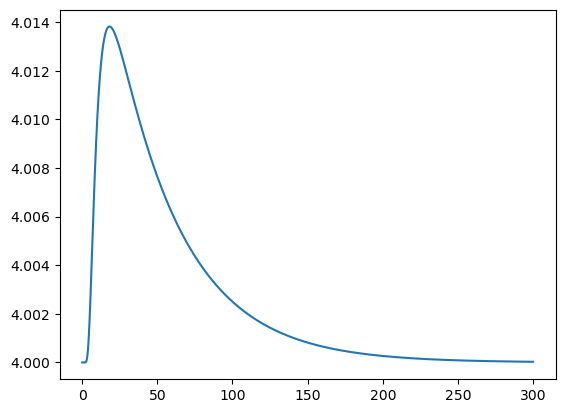

In [215]:

t, sig = getSignature((10, 1, 5), 100, tmax=300)
plt.plot(t, sig)